In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
from src.preprocess.VoiceBankDEMAND import VoiceBandDEMAND
from src.preprocess.feature_extractor import FeatureExtractor
from src.utils import read_audio, load_yaml
from src.distrib import load_model

# Load the TensorBoard notebook extension.
# %load_ext tensorboard

from tensorflow.python.client import device_lib

# SHOULD PUT model path
model_path = Path(f'./result/gru/20230110-144834')
path_conf = os.path.join(model_path, "config.yaml")
args = load_yaml(path_conf)
args.model.path = model_path.as_posix()

Found GPU at: /device:GPU:0


2023-01-10 14:49:56.021011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 14:49:56.021040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# 1. Load Paramter
device_lib.list_local_devices()
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

model_name = args.model.name
save_path = args.dset.save_path
flag_fft = args.dset.fft
nfft = args.dset.n_fft
hop_length = args.dset.hop_length
center = args.dset.center
num_features = args.model.n_feature
normalization = args.dset.normalize
top_db = args.dset.top_db
train_split = int(args.dset.split*100)
sample_rate = args.dset.sample_rate
win_length = args.dset.win_length
segment = args.dset.segment
num_segments = int(segment*sample_rate//hop_length + 1)

2023-01-10 14:49:56.080654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 14:49:56.080683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# 3. Build and Load Model
model = load_model(args)

2023-01-10 14:49:56.368385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-10 14:49:56.368408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1, 64, 257)  0           []                               
                                ]                                                                 
                                                                                                  
 magnitude (Magnitude)          (None, 1, 64, 257)   0           ['input[0][0]']                  
                                                                                                  
 tf.compat.v1.squeeze (TFOpLamb  (None, 64, 257)     0           ['magnitude[0][0]']              
 da)                                                                                              
                                                                                              

In [6]:
# Load audio file
dataset_path = "/Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791"
dataset_voicebank = VoiceBandDEMAND(dataset_path, val_dataset_percent=0.3)
clean_test_filenames, noisy_test_filenames = dataset_voicebank.get_test_filenames()
clean_file = clean_test_filenames[3] 
noisy_file = noisy_test_filenames[3]

clean_file = "/Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_005.wav"
noisy_file = "/Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_005.wav"

# clean_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/clean.wav"
# noisy_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/dirty.wav"

File example:
Clean:  /Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_001.wav The number:  824
Noisy:  /Users/seunghyunoh/workplace/research/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_001.wav The number:  824
# of Noise testing files: 824


In [7]:
# 4. Load audio files
clean_audio, sr = read_audio(clean_file, sample_rate)
noisy_audio, sr = read_audio(noisy_file, sample_rate)

mean_noisy = np.mean(noisy_audio)
std_noisy = np.std(noisy_audio)
noisy_audio_norm = (noisy_audio - mean_noisy) / std_noisy

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
# 5. Prepare input for ML Models
def _prepare_input_stft_zero_filled(stft, numSegments, numFeatures, pad=True):
    if pad:
        stft_padded = np.concatenate([np.zeros_like(stft[:, 0:numSegments - 1]), stft], axis=-1)

    segments = np.zeros((numFeatures, numSegments, stft_padded.shape[1] - numSegments + 1), dtype=stft.dtype)
    
    for index in range(stft_padded.shape[1] - numSegments + 1):
        segments[..., index] = stft_padded[..., index:index + numSegments]
    
    return segments

def _prepare_input_wav_zero_filled(wav, num_feature, stride):
    assert wav.shape[-1] >= num_feature, "the length of data is too short comparing the number of features..."

    if (wav.shape[-1] - num_feature) % stride != 0:
        npad = stride*((wav.shape[-1] - num_feature)//stride + 1) - (wav.shape[-1] - num_feature)
        padding = np.zeros(shape=(len(wav.shape)*2), dtype=int)
        padding[-1] = npad
        padding = np.reshape(padding, newshape=(len(wav.shape), 2))
        wav_padded = np.pad(wav, pad_width=padding, mode="constant", constant_values=0)
    else:
        wav_padded = wav

    num_segment = (wav_padded.shape[-1] - num_feature) // stride +1

    shape = list(wav.shape)
    shape = [num_segment] + shape[:-1] + [num_feature]
    wav_segments = np.zeros(shape=shape, dtype=wav.dtype)
    
    for index in range(num_segment):
        wav_segments[index, ...] = wav_padded[..., index*stride:index*stride+num_feature]
    
    return wav_segments

if model_name in ("unet"):
    num_feature = int(sample_rate*segment)
    stride = 256
    noisy_input = _prepare_input_wav_zero_filled(noisy_audio_norm, num_feature=num_feature, stride=stride)
    noisy_input = np.expand_dims(noisy_input, axis=1)
else:
    noisy_audio_feature_extractor = FeatureExtractor(noisy_audio_norm, windowLength=win_length, hop_length=hop_length, sample_rate=sr)
    noisy_stft_features = noisy_audio_feature_extractor.get_stft_spectrogram(center)

    noisy_stft_features /= nfft

    noisy_input = _prepare_input_stft_zero_filled(noisy_stft_features, num_segments, num_features)
    noisy_input = np.transpose(noisy_input, axes=(2, 1, 0))
    noisy_input = np.expand_dims(noisy_input, axis=1)

In [9]:
# 6. Model Output
output = model.predict(noisy_input)
if model_name in ("unet"):
    shape = list(noisy_audio_norm.shape)
    shape = shape[:-1] + [num_feature + stride*(output.shape[0]-1)]
    estimation = np.zeros(shape=shape, dtype=noisy_audio_norm.dtype)
    estimation[..., :num_feature] = output[0, ...]
    for ibatch in range(output.shape[0]-1):
        curr_loc = num_feature + stride*ibatch
        estimation[..., curr_loc: curr_loc+stride] = output[ibatch+1, ..., -stride:]

    estimation = estimation[..., :noisy_audio_norm.shape[-1]]
    estimation = estimation*mean_noisy + std_noisy
else:
    output = output[..., -1, :]
    output = np.squeeze(output)

    def revert_features_to_audio(stft, mean=None, std=None):
        stft = np.transpose(stft, (1, 0))
        stft *= nfft
        estimated_audio = noisy_audio_feature_extractor.get_audio_from_stft_spectrogram(stft, center)
        
        # scale the outpus back to the original range
        if mean and std:
            estimated_audio = std * estimated_audio + mean
        
        return estimated_audio
    estimation = revert_features_to_audio(output, mean_noisy, std_noisy)

2023-01-10 14:49:59.201768: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-10 14:49:59.377701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-10 14:49:59.493223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-10 14:49:59.625588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 45ms/step


In [12]:
# 7. Metric
metric_sisdr = None

filename = clean_file.split('/')[-1].split('.')[0]
metric_sisdr = {filename:{}}

if model_name in ("unet"):
    noisy_bypass = mean_noisy*noisy_audio_norm + std_noisy
    clean_bypass = clean_audio
else:
    mean_clean = np.mean(clean_audio)
    std_clean = np.std(clean_audio)
    clean_audio_norm = (clean_audio - mean_clean) / std_clean
    clean_audio_feature_extractor = FeatureExtractor(clean_audio_norm, windowLength=win_length, hop_length=hop_length, sample_rate=sr)
    clean_stft_features = clean_audio_feature_extractor.get_stft_spectrogram(center)
    clean_stft_features /= nfft
    
    noisy_bypass = noisy_input[..., -1, :]
    noisy_bypass = np.squeeze(noisy_bypass)
    noisy_bypass = revert_features_to_audio(noisy_bypass, mean_noisy, std_noisy)

    clean_input = _prepare_input_stft_zero_filled(clean_stft_features, num_segments, num_features)
    clean_input = np.transpose(clean_input, (2, 1, 0))
    clean_input = np.expand_dims(clean_input, axis=1)

    clean_bypass = clean_input[..., -1, :]
    clean_bypass = np.squeeze(clean_bypass)
    clean_bypass = revert_features_to_audio(clean_bypass, mean_clean, std_clean)

estimation_metric = estimation

from src.model.metrics import SI_SDR

metric = SI_SDR

new_shape = list(clean_bypass.shape)
nsegment_metric = int(new_shape[-1]//sample_rate)
new_shape += [0]
new_shape[-2:] = nsegment_metric, sample_rate

clean_bypass = clean_bypass[:nsegment_metric*sample_rate]
clean_bypass = np.reshape(clean_bypass, new_shape)
noisy_bypass = noisy_bypass[:nsegment_metric*sample_rate]
noisy_bypass = np.reshape(noisy_bypass, new_shape)
estimation_metric = estimation[:nsegment_metric*sample_rate]
estimation_metric = np.reshape(estimation_metric, new_shape)

metric_sisdr[filename]['sisdr'] = {}
for nseg, (clean_seg, noisy_seg, est_seg) in enumerate(zip(clean_bypass, noisy_bypass, estimation_metric)):
    sisdr_prev = metric(clean_seg, noisy_seg, sample_rate)
    sisdr_after = metric(clean_seg, est_seg, sample_rate)
    metric_sisdr[filename]['sisdr'][(nseg)] = [sisdr_prev, sisdr_after]
    
sisdr_prev = metric(clean_bypass, noisy_bypass, sample_rate)
sisdr_after = metric(clean_bypass, estimation_metric, sample_rate)
metric_sisdr[filename]['sisdr']['total'] = [sisdr_prev, sisdr_after]

Text(0.5, 1.0, 'Denoised Audio')

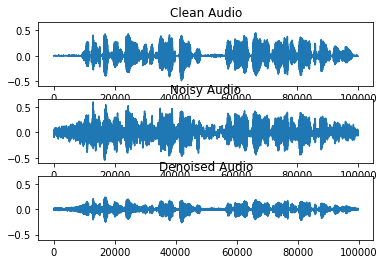

In [14]:
# plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(clean_audio)
ax1.set_title("Clean Audio")

ax2.plot(noisy_audio)
ax2.set_title("Noisy Audio")

ax3.plot(estimation)
ax3.set_title("Denoised Audio")


In [15]:
import IPython.display as ipd

In [20]:
ipd.Audio(data=clean_audio, rate=sample_rate) # load a local WAV file

In [21]:
ipd.Audio(data=noisy_audio, rate=sample_rate) # load a local WAV file

In [22]:
ipd.Audio(data=estimation, rate=sample_rate) # load a local WAV file

In [23]:
import numpy as np
import librosa
import librosa.display

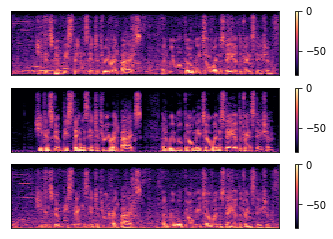

In [25]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharey=True)

def show_stft(y, _fig, _ax):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _fig.colorbar(img, ax=_ax)

show_stft(estimation, fig, ax0)
show_stft(clean_audio, fig, ax1)
show_stft(noisy_audio, fig, ax2)

In [26]:
# bose_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/proc.wav"
# boseAudio, sr = read_audio(bose_file, sample_rate)
# ipd.Audio(data=boseAudio, rate=sample_rate)